#**Get the Image Data Set From Github and create a Folder**

In [1]:
!git clone https://github.com/Hrushi11/Real-TIme-Skin-Type-Detection.git

Cloning into 'Real-TIme-Skin-Type-Detection'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 548 (delta 0), reused 3 (delta 0), pack-reused 545
Receiving objects: 100% (548/548), 234.11 MiB | 12.85 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (541/541), done.


In [2]:
import os
import shutil
src_dir ='/content/Real-TIme-Skin-Type-Detection/skin-dataset/oily'
datafile = '/content/datafile' #create a folder to move images in repository
files = os.listdir(src_dir)
shutil.copytree(src_dir, datafile)

'/content/datafile'

#**Image Augmentation and Saving Images in a Separate Folders**

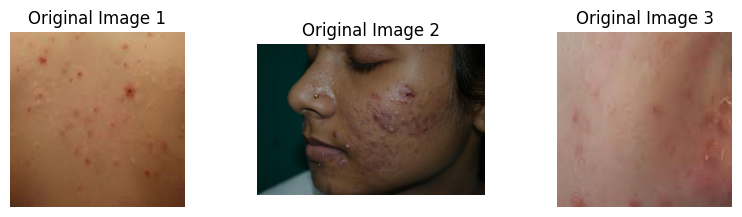

In [3]:
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Set the paths for the original and augmented images
original_folder = "/content/datafile"
augmented_folder = "/content/augmented_folder"

# Create the augmented folder if it doesn't exist
os.makedirs(augmented_folder, exist_ok=True)

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load some original images
original_images = []
for img_name in os.listdir(original_folder)[:3]:  # Displaying 3 original images
    img_path = os.path.join(original_folder, img_name)

    # Check if the file is an image
    if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(img_path)

        # Check if the image was successfully loaded
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            original_images.append(img)

# Display original images
plt.figure(figsize=(10, 5))
for i in range(len(original_images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(original_images[i])
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

# Save augmented images
for img_name in os.listdir(original_folder):
    img_path = os.path.join(original_folder, img_name)

    # Check if the file is an image
    if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(img_path)

        # Check if the image was successfully loaded
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.reshape((1,) + img.shape)

            for i, batch in enumerate(datagen.flow(img, batch_size=1, save_to_dir=augmented_folder, save_prefix='aug', save_format='jpeg')):
                if i >= 4:  # adjust the number of augmentations as needed
                    break


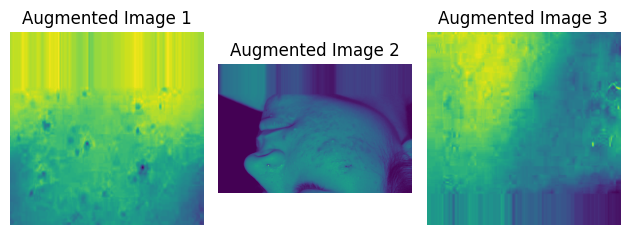

In [4]:
# Load and display augmented images
augmented_images = []
for i in range(len(original_images)):
    original_img = original_images[i]
    # Convert to 2D array if needed
    if original_img.ndim == 3:
        original_img = original_img[:, :, 0]
    augmented_img = datagen.random_transform(original_img.reshape((1,) + original_img.shape))
    augmented_img = augmented_img.squeeze()

    plt.subplot(2, 3, i + 4)
    plt.imshow(augmented_img.astype(int))  # Convert to int for display
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


#**K Mean Clustering for Augmented Images**

In [5]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Read and preprocess augmented images
augmented_images = []
for img_name in os.listdir(augmented_folder):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize all images to a common size
    augmented_images.append(img.flatten())

# Convert list to NumPy array
augmented_images = np.array(augmented_images)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(augmented_images)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


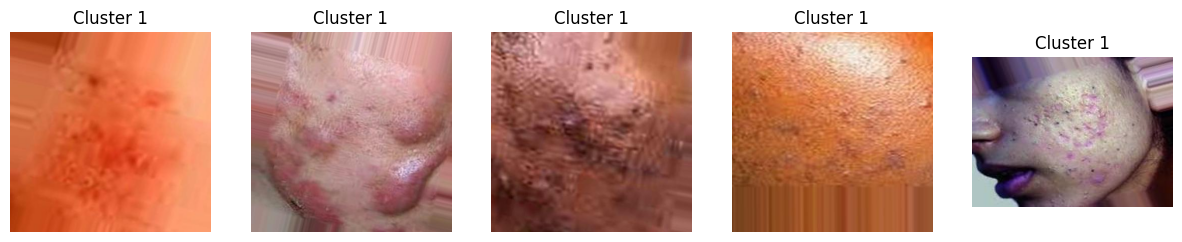

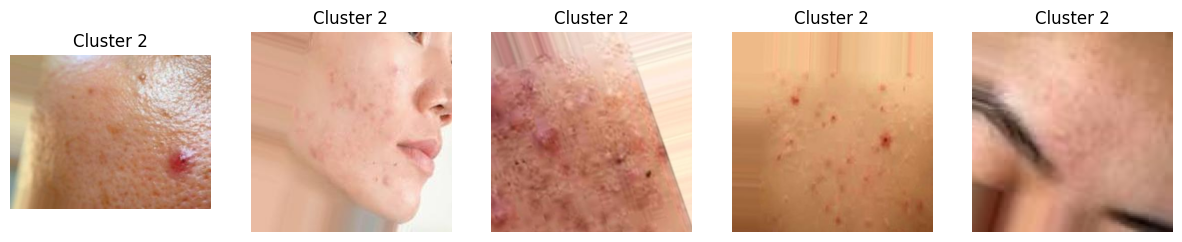

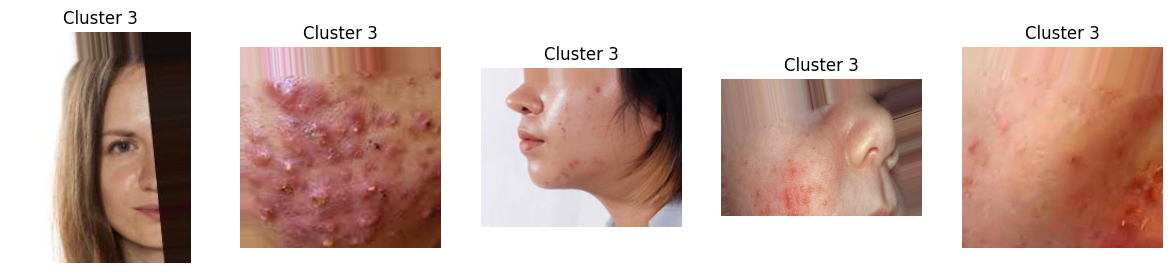

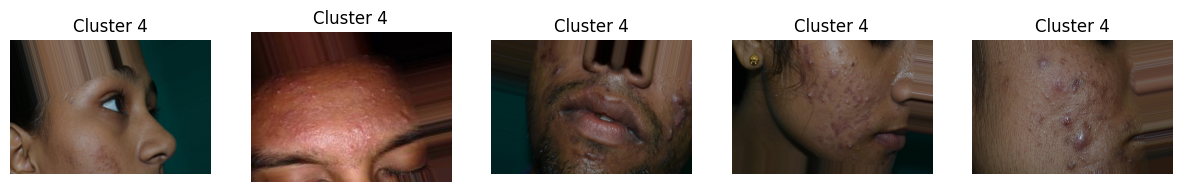

In [6]:
# Visualize the results
for cluster_num in range(4):
    cluster_indices = np.where(clusters == cluster_num)[0]
    plt.figure(figsize=(15, 3))

    for i, img_index in enumerate(cluster_indices[:5]):  # Displaying up to 5 images from each cluster
        img_path = os.path.join(augmented_folder, os.listdir(augmented_folder)[img_index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Cluster {cluster_num + 1}')
        plt.axis('off')

    plt.show()

In [7]:
# Print the category number and number of images in each category
for category_num in range(4):
    category_indices = np.where(clusters == category_num)[0]
    print(f"Oiliness Category {category_num + 1}: {len(category_indices)} images")

Oiliness Category 1: 151 images
Oiliness Category 2: 258 images
Oiliness Category 3: 165 images
Oiliness Category 4: 112 images


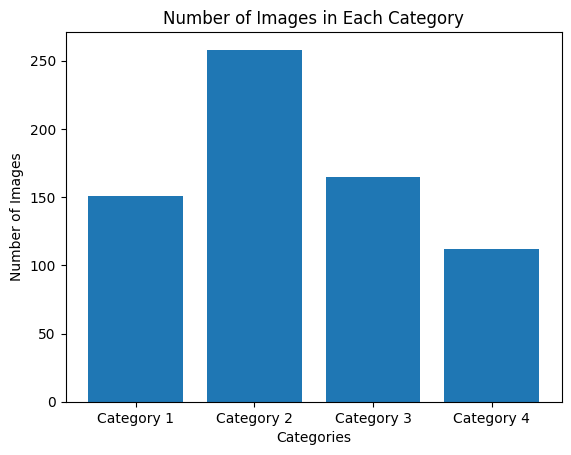

In [8]:
# Count the number of images in each category
category_counts = [np.sum(clusters == category_num) for category_num in range(4)]

# Plot the bar chart
categories = ["Category 1", "Category 2", "Category 3", "Category 4"]
plt.bar(categories, category_counts)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.show()

# **Categorization and Saving**

In [9]:
categorized_folder = "/content/categorized_folder"

# Create folders for each category
for i in range(4):
    os.makedirs(os.path.join(categorized_folder, f"category_{i+1}"), exist_ok=True)

# Move images to their respective categories
for i, img_name in enumerate(os.listdir(augmented_folder)):
    img_path = os.path.join(augmented_folder, img_name)
    category = clusters[i] + 1  # clusters are 0-indexed, so adding 1 to start from category_1
    category_folder = os.path.join(categorized_folder, f"category_{category}")
    os.rename(img_path, os.path.join(category_folder, img_name))


# **Splitting the Data to Training**

In [10]:
from sklearn.model_selection import train_test_split

train_folder = "/content/training"
valid_folder = "/content/validation"

# Iterate through each category and split data
for i in range(1, 5):
    category_folder = os.path.join(categorized_folder, f"category_{i}")
    images = os.listdir(category_folder)

    # Check if there are images in the category folder
    if len(images) > 0:
        train_images, valid_images = train_test_split(images, test_size=0.2, random_state=42)

        # Move images to training folder
        for img_name in train_images:
            src_path = os.path.join(category_folder, img_name)
            dest_path = os.path.join(train_folder, f"category_{i}", img_name)
            os.makedirs(os.path.join(train_folder, f"category_{i}"), exist_ok=True)
            os.rename(src_path, dest_path)

        # Move images to validation folder
        for img_name in valid_images:
            src_path = os.path.join(category_folder, img_name)
            dest_path = os.path.join(valid_folder, f"category_{i}", img_name)
            os.makedirs(os.path.join(valid_folder, f"category_{i}"), exist_ok=True)
            os.rename(src_path, dest_path)
    else:
        print(f"No images found in {category_folder}. Skipping split.")


#**CNN Model**

In [11]:
from keras.applications import VGG16
from keras import layers
from keras import models

# Create the base model with pre-trained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build a custom model on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 4s 0us/step


#**Model Training**

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# Set the paths for training and validation data
train_folder = "/content/training"
valid_folder = "/content/validation"

# Set image dimensions
img_width, img_height = 224, 224

# Set batch size
batch_size = 16

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
epochs = 15  # adjust as needed
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
)

# Save the trained model
model.save("path/to/saved/model.h5")

# Evaluate the model
loss, accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Found 547 images belonging to 4 classes.
Found 139 images belonging to 4 classes.
Epoch 1/15
34/34 [==============================] - 30s 366ms/step - loss: 1.7861 - accuracy: 0.3409 - val_loss: 1.1954 - val_accuracy: 0.4844
Epoch 2/15
34/34 [==============================] - 8s 234ms/step - loss: 1.0647 - accuracy: 0.5424 - val_loss: 1.4035 - val_accuracy: 0.2656
Epoch 3/15
34/34 [==============================] - 8s 226ms/step - loss: 0.9386 - accuracy: 0.6403 - val_loss: 0.4426 - val_accuracy: 0.8125
Epoch 4/15
34/34 [==============================] - 8s 237ms/step - loss: 0.5213 - accuracy: 0.7834 - val_loss: 0.4482 - val_accuracy: 0.8594
Epoch 5/15
34/34 [==============================] - 8s 232ms/step - loss: 0.5460 - accuracy: 0.8173 - val_loss: 0.2908 - val_accuracy: 0.8750
Epoch 6/15
34/34 [==============================] - 9s 245ms/step - loss: 0.4697 - accuracy: 0.8117 - val_loss: 0.3662 - val_accuracy: 0.8516
Epoch 7/15
34/34 [==============================] - 8s 231ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 478ms/step - loss: 0.3492 - accuracy: 0.8273
Validation Loss: 0.3492
Validation Accuracy: 82.73%


# **Colab Face Detetction code using web cam**

Imports

In [13]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

starting web cam

In [32]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

press cature to take a photo

In [72]:
image_file = take_photo()

<IPython.core.display.Javascript object>

resize the image

400 300


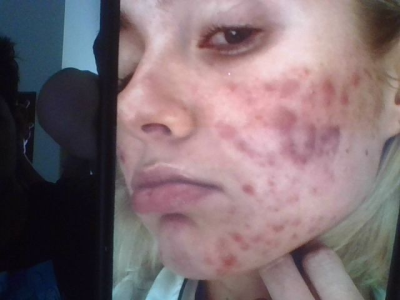

In [61]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

Download the pre-trained face detection model, consisting of two files:

- The network definition (deploy.prototxt)
- The learned weights (res10_300x300_ssd_iter_140000.caffemodel)

In [35]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2024-02-20 08:51:23--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2024-02-20 08:51:23 (147 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2024-02-20 08:51:23--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

In [73]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model_capture = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model_capture)

[INFO] loading model...


In [74]:
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [75]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


In [76]:
for i in range(0, detections.shape[2]):

	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# draw the bounding box of the face along with the associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

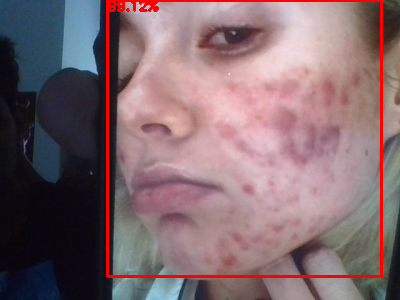

In [77]:
cv2_imshow(image)

# **Skin detection Code**

In [23]:
!git clone https://github.com/mpatacchiola/deepgaze.git

Cloning into 'deepgaze'...
remote: Enumerating objects: 1324, done.
remote: Total 1324 (delta 0), reused 0 (delta 0), pack-reused 1324
Receiving objects: 100% (1324/1324), 239.15 MiB | 13.87 MiB/s, done.
Resolving deltas: 100% (733/733), done.
Updating files: 100% (170/170), done.


In [24]:
!pip install /content/deepgaze

Processing ./deepgaze
  Preparing metadata (setup.py) ... done
  Created wheel for deepgaze: filename=deepgaze-0.1-py3-none-any.whl size=40413 sha256=fa12632aba7f0aeab723eb60e84df6c18669141456c2161b08ad55ce38c69b44
  Stored in directory: /tmp/pip-ephem-wheel-cache-_cs1lcxo/wheels/06/cb/99/3f1cfaa91774996b3acd87bf32f415e5e536ed238eb3ededb2
Successfully built deepgaze


In [25]:
import numpy as np
import cv2
from deepgaze.color_detection import RangeColorDetector
from matplotlib import pyplot as plt

In [66]:
min_range = np.array([0, 48, 70], dtype = "uint8") #lower HSV boundary of skin color
max_range = np.array([20, 150, 255], dtype = "uint8") #upper HSV boundary of skin color
my_skin_detector = RangeColorDetector(min_range, max_range) #Define the detector object
image = cv2.imread("/content/photo.jpg") #Read the image with OpenCV
#We do not need to remove noise from this image so morph_opening and blur are se to False
image_filtered = my_skin_detector.returnFiltered(image, morph_opening=False, blur=False, kernel_size=3, iterations=1)
cv2.imwrite("testing_image.jpg", image_filtered) #Save the filtered image

True

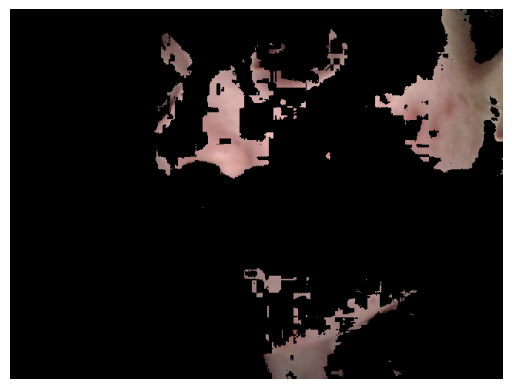

In [67]:
plt.imshow(cv2.cvtColor(image_filtered, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

#**Testing the Image**

preprocess the testing image

In [82]:
import cv2
import numpy as np

test_image_path = "/content/testing_image.jpg"  # Replace with the actual path to your test image
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Ensure the correct color format
test_image = cv2.resize(test_image, (224, 224))  # Resize to match the input size used during training
test_image = test_image / 255.0  # Normalize pixel values to the range [0, 1]

# Reshape the image to match the input shape expected by your model
test_image = np.reshape(test_image, (1, 224, 224, 3))


loading the model

In [83]:
from keras.models import load_model

model_path = "path/to/saved/model.h5"  # Replace with the actual path to your saved model
model = load_model(model_path)


In [84]:
# Make predictions
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)

1/1 [==============================] - 0s 161ms/step


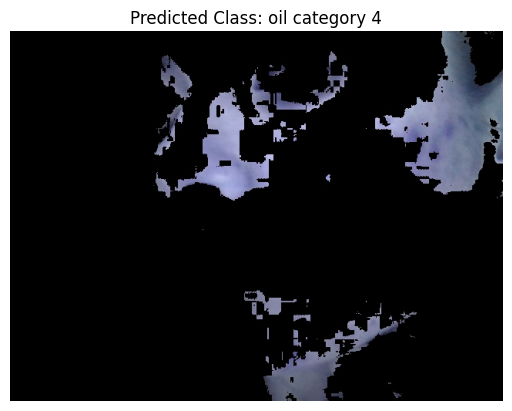

In [85]:
import matplotlib.pyplot as plt

# Assuming you have a list of class labels
class_labels = ["oil category 1", "oil category 2", "oil category 3", "oil category 4"]

plt.imshow(cv2.imread(test_image_path))
plt.title(f"Predicted Class: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
